# Clustering workshop for Insight Data Science

We will give a basic overview of k-means clustering and its possible pitfalls, and we will also explore a few alternatives to k-means:

1. Expectation-Maximization of Gaussian Mixture Models
2. DBSCAN
3. HDBSCAN

In addition to this guide, if you are interested knowing more about clustering, I would highly recommend checking out these additional resources for clustering algorithms/problems:

* <https://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means>
* <http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html>
* <http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html>

In [74]:
# Some imports
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.cluster as cluster
import sklearn.mixture as mixture
from sklearn import datasets
from scipy.spatial.distance import cdist

In [131]:
# We'll also define a plotting function to keep things clean later on.
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    # plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    plt.scatter(data[:,0], data[:,1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)

## K-means clustering
This is everyone's favorite clustering problem. It's easy, it's fast, and for spherically clustered data, it works quite well. We'll start with a case where k-means clustering __does__ work well.

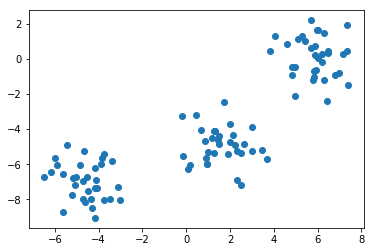

In [9]:
# Make some blobs! (and visualize them)
blobs_X, blobs_Y = datasets.make_blobs(n_features=2, centers=3)
plt.scatter(blobs_X[:, 0], blobs_X[:, 1])
plt.show()

The data above has three well-separated, roughly spherical clusters. Let's apply k-means clustering and examine the result.

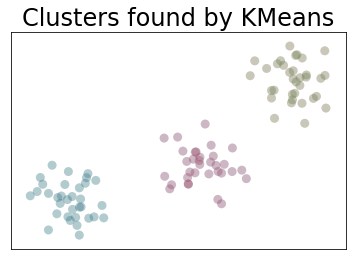

In [18]:
plot_clusters(blobs_X, cluster.KMeans, (), {'n_clusters':3})
plt.show()

In this case, K-means has provided an answer we are fairly sure is correct. But in this case, it was very clear that 3 clusters were present. One of the more dangerous things about k-means is that it will *always* give you an answer. Consider another example:

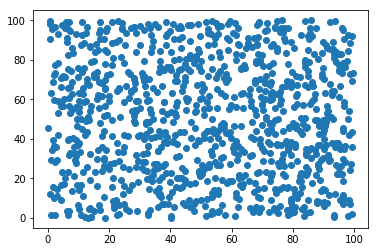

In [28]:
random_data_pts = np.random.uniform(0, 100, (1000, 2))
plt.scatter(random_data_pts[:, 0], random_data_pts[:, 1])
plt.show()

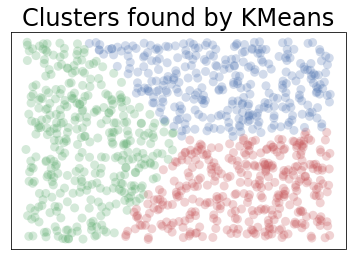

In [29]:
plot_clusters(random_data_pts, cluster.KMeans, (), {'n_clusters':3})
plt.show()

It's not clear that there is any particular meaning to 3 clusters in this data - k-means will partition the data however you tell it to:

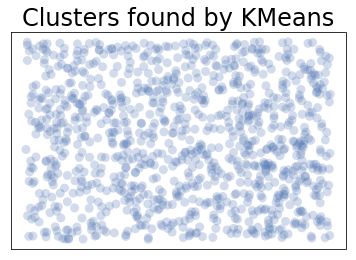

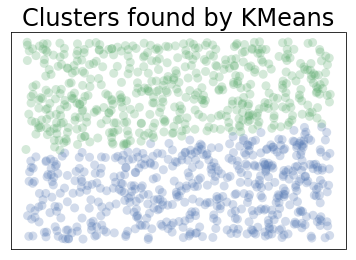

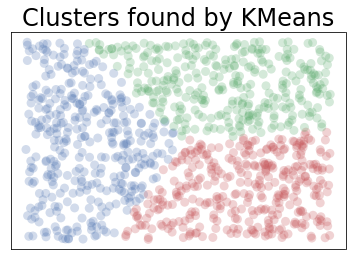

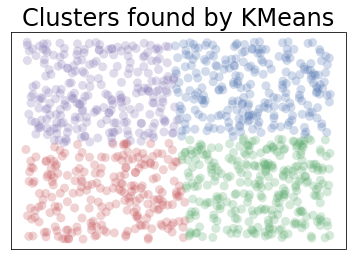

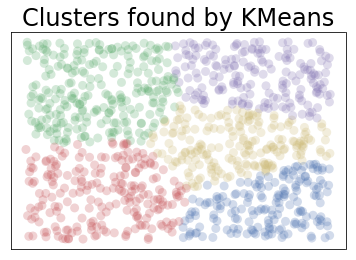

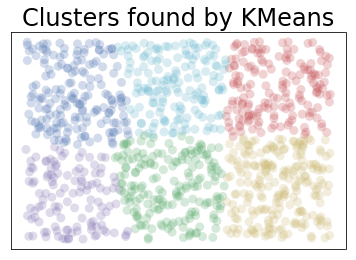

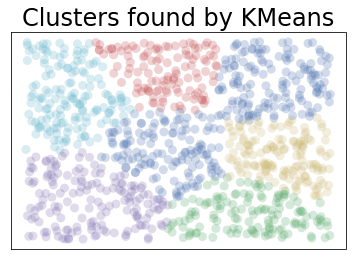

In [32]:
for k in range(1, 8):
    plot_clusters(random_data_pts, cluster.KMeans, (), {'n_clusters': k})
    plt.show()

How do we choose the number of clusters? There are several methods for doing this - in fact, estimating the number of clusters present in data is practically a field unto itself, and at present, there is no single, generally-applicable, statistically-rigorous way to do this. Below, we'll review two of the most common methods:

1. The Elbow Method - the idea here is to maximize the tradeoff between having clusters large enough that we care about them while at the same time minimizing the distance between points and centroids.
2. The Silhouette Method - the idea here to look at the ratio of how "cohesive" (tightly-held-together) a cluster is to how far it is from other clusters. Ideal clustering yields tightly-packed, well-separated clusters, which will produce a high silhouette score.

To do this, we'll go back to our simple "blobs" data set.  The code for generating the silhouette plots was repurposed from <http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>.

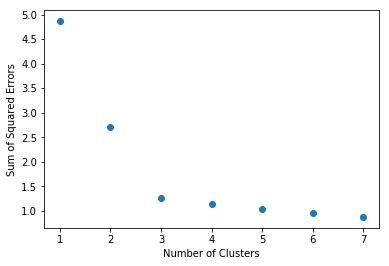

In [88]:
# Elbow method
sum_squared_errors = []
for k in range(1, 8):
    model = cluster.KMeans(n_clusters=k).fit(blobs_X)
    sum_squared_errors.append(sum(np.min(cdist(blobs_X, model.cluster_centers_, 'euclidean'), axis=1)) / blobs_X.shape[0])
plt.scatter(range(1, 8), sum_squared_errors)
plt.ylabel("Sum of Squared Errors")
plt.xlabel("Number of Clusters")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.598890366876


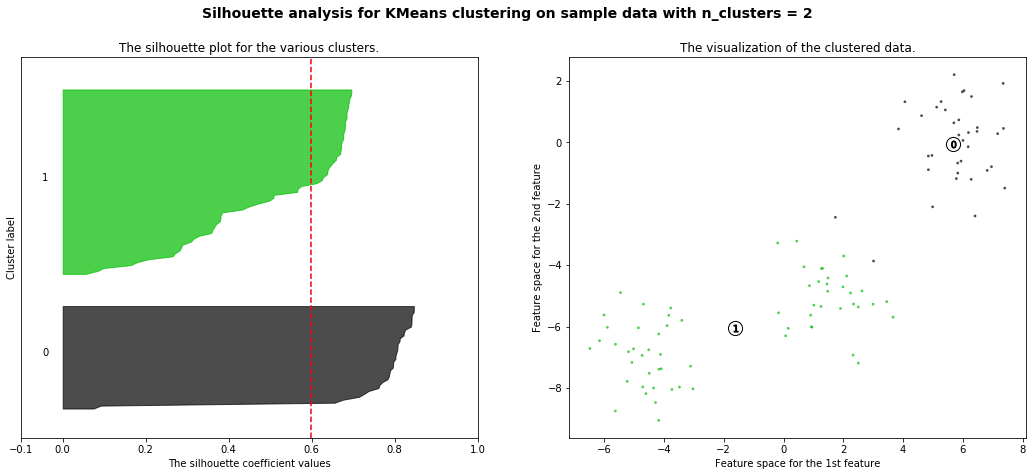

For n_clusters = 3 The average silhouette_score is : 0.715544591251


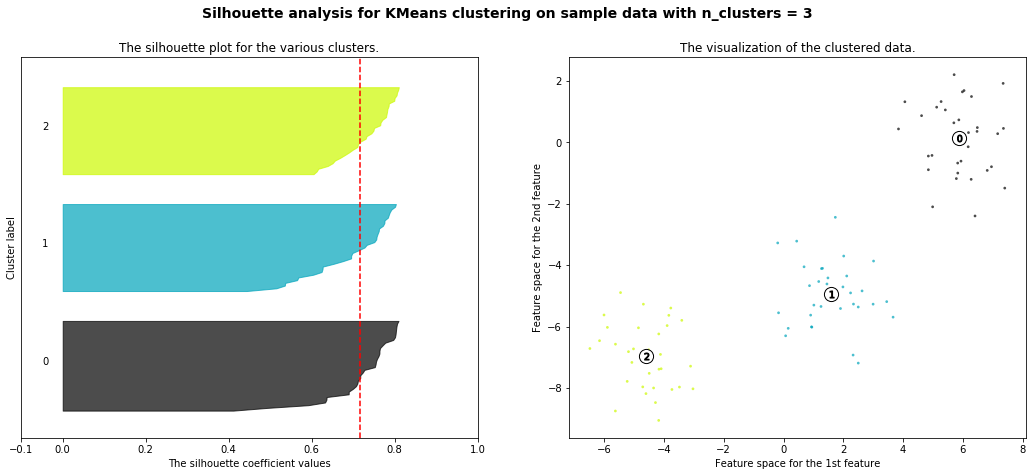

For n_clusters = 4 The average silhouette_score is : 0.589863350092


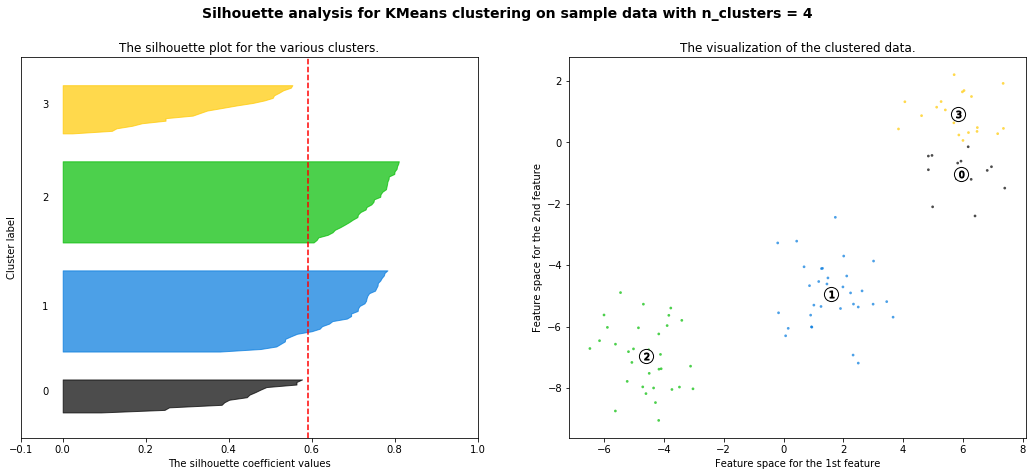

For n_clusters = 5 The average silhouette_score is : 0.478882426231


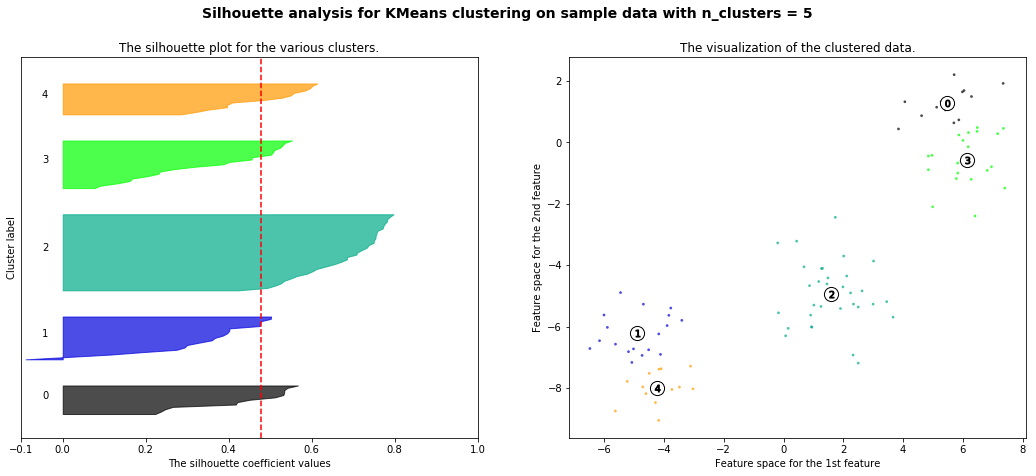

For n_clusters = 6 The average silhouette_score is : 0.364191785721


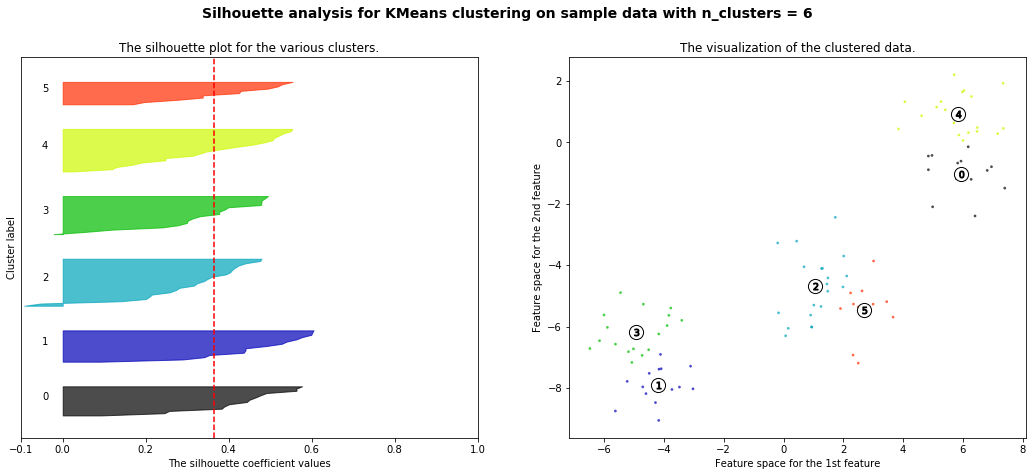

In [51]:
# Silhouette method
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6]
average_silhouette_scores = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(blobs_X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(blobs_X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(blobs_X, cluster_labels)
    average_silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(blobs_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(blobs_X[:, 0], blobs_X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

As you can see above, the silhouette method gives us a bit more information to discriminate between two and three clusters as compared to the elbow method. The "intuitive" number of clusters in this data set is clearly 3, and in the silhouette plots above, n_clusters = 3 produces silhouettes that are very similar in size and and all close to the average score - a sign of good clustering.  More crudely, we an also just examine what number of clusters maximizes the average silhouette score.

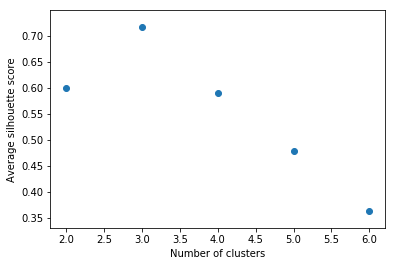

In [48]:
plt.scatter(range_n_clusters, average_silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.show()

We have established that with well-separated, spherical clusters and appropriate choice of cluster number, k-means can very effectively cluster the *right* type of data. What about something like this?

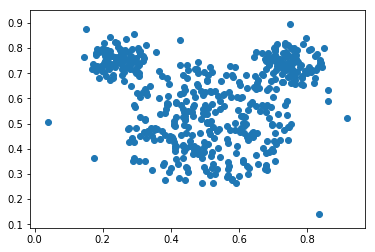

In [69]:
mouse_data = pd.read_csv("mouse.csv", usecols=[0,1], header=None).as_matrix()
plt.scatter(mouse_data[:, 0], mouse_data[:, 1])u
plt.show()

How does k-means cluster this data?

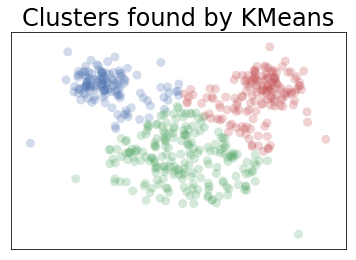

In [70]:
plot_clusters(mouse_data, cluster.KMeans, (), {'n_clusters':3})
plt.show()

K-means generally tries to create clusters of equal "area" in your feature space as a consequence of the way it partitions data, and that's why Mickey's ears get grouped with his head.  An alternative is performing expectation-maximization on Gaussian Mixture Models.

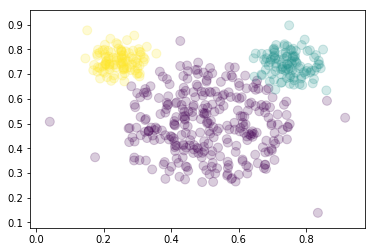

In [91]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(mouse_data)
y_pred = gmm.predict(mouse_data)
plt.scatter(mouse_data[:,0], mouse_data[:,1], c=y_pred, alpha=0.2, s=80)
plt.show()

We see above that Gaussian Mixture Models do a much better job on our Mickey Mouse data. This is in part because it better tolerates clusters having different sizes (we can choose a Gaussian of width1 and a Gaussian of width2 and those widths need not be the same). The preference of k-means to generate clusters of equal size is not entirely intuitive, but stems from its need to assign every point, even distant points, to _some_ centroid.

Everything we have discussed so far assumes our data contains _convex_ clusters. That means that every point in the cluster can be connected by a line entirely inside that cluster. For a more rigorous definition (including instructive diagrams on the first page), see: <https://www2.stat.duke.edu/courses/Spring12/sta376/lec/optim.pdf>. What about non-convex data like the 2D set shown below?

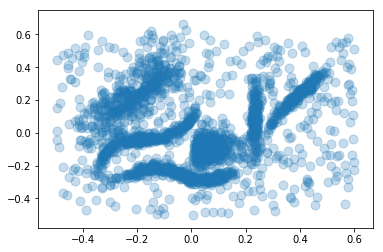

In [95]:
messy_data = np.load('clusterable_data.npy')
plt.scatter(messy_data[:, 0], messy_data[:, 1], s=80, alpha=0.25)
plt.show()

Although this data is messy from a clustering standpoint, there are still some fairly obvious clusters present - they just have a weird shape.  Let's go through analyzing this set first with k-means clustering.

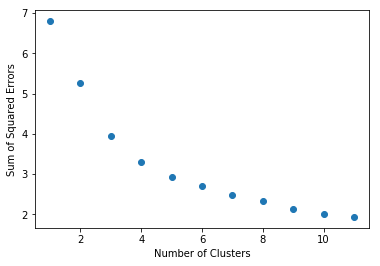

In [125]:
# k-means
## Elbow method to get ideal number of clusters
sum_squared_errors = []
for k in range(1, 12):
    model = cluster.KMeans(n_clusters=k).fit(messy_data)
    sum_squared_errors.append(sum(np.min(cdist(messy_data, model.cluster_centers_, 'euclidean'), axis=1)) / blobs_X.shape[0])
plt.scatter(range(1, 12), sum_squared_errors)
plt.ylabel("Sum of Squared Errors")
plt.xlabel("Number of Clusters")
plt.show()

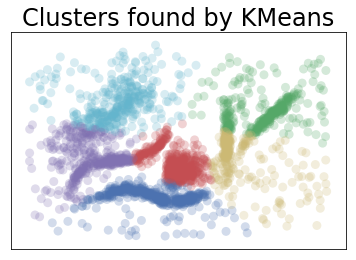

In [130]:
# The elbow isn't immediately obvious, but let's choose 6, because that's what one would "eyeball" from looking at the data.
plot_clusters(messy_data, cluster.KMeans, (), {'n_clusters':6})
plt.show()

We can see that this doesn't perform too well, splitting these clusters arbitrarily.  What about Expectation-Maximization of Gaussian Mixture models?

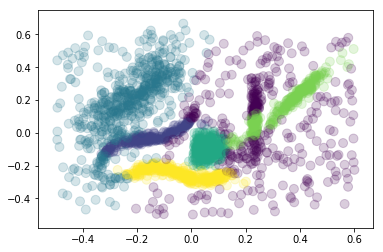

In [110]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full')
gmm.fit(messy_data)
y_pred = gmm.predict(messy_data)
plt.scatter(messy_data[:,0], messy_data[:,1], c=y_pred, alpha=0.2, s=80)
plt.show()

While this is perhaps better, the GMM also messes this up, particularly with the green cluster above.  Data sets like this are begging for a density-based clustering algorithm, the most famous of which is DBSCAN. DBSCAN is a density based clustering algorithm that clusters data by examining how many points can be reached within a particular distance of a point. I won't re-invent the wheel, but an excellent explanation of DBSCAN can be found here: <https://blog.dominodatalab.com/topology-and-density-based-clustering/>. The key advantages of DBSCAN are two-fold:

1. It doesn't care about cluster shape (clusters are free to be non-convex).
2. The number of clusters does not need to be chosen in advance - DBSCAN will find the number of clusters that emerge for a given density threshold.

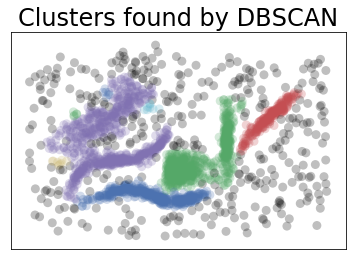

In [117]:
# DBSCAN
plot_clusters(messy_data, cluster.DBSCAN, (), {'eps':0.025})
plt.show()

This is much better than k-means or Gaussian mixture models, but there is still some weirdness. First, there are two pairs of clusters (purple and green) which get grouped into one cluster. Secondly, there are some strange cluster memberships forming on the periphery of the the purple cluster, shown in yellow, blue, and green. DBSCAN has two critical weaknesses:

1. The hyperparameters of DBSCAN are generally not intuitive and must be carefully chosen, as DBSCAN is extremely sensitive to them (change 'eps' to 0.030 above if you don't believe me).
2. DBSCAN considers only a fixed density threshold to define the notion of a cluster. That's why it's difficult for DBSCAN to distinguish clusters of variable density, like the purple cluster in the above image.

To address this issues, HDBSCAN was developed. An excellent, step-by-step explanation of what HDBSCAN is doing under the hood can be found here: <http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html>.  For now, suffice it to say that HDBSCAN has all of the advantages of DBSCAN with two additional advantages:

1. The only hyperparameter is the minimum cluster size, which, while not entirely intuitive, is more easily understood and chosen than the parameters of DBSCAN.
2. HDBSCAN finds the clusters which persist through the largest range of densities and so can identify clusters of variable density.  This point is not immediately clear, but the link above begins to explain how this is accomplished.

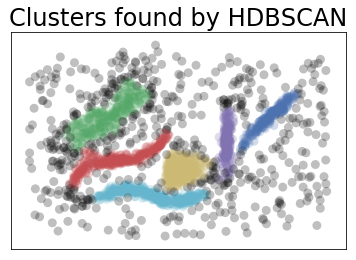

In [123]:
# HDBSCAN
import hdbscan
plot_clusters(messy_data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})
plt.show()

This pretty much gets it right. Not every point here is assigned to a cluster - this is one of the strengths of HDBSCAN; outliers need not influence the cluster shape. Indeed, one of the primary applications of density based clustering is unsupervised outlier detection, a few examples of which are shown below:

* Tutorial: <http://hdbscan.readthedocs.io/en/latest/outlier_detection.html>
* Netflix: <https://medium.com/netflix-techblog/tracking-down-the-villains-outlier-detection-at-netflix-40360b31732>
* FraudHacker (Dan's Insight project): <http://www.fraudhacker.site/about>

We've only scratched the surface - clustering is an entire sub-field of unsupervised machine learning. A few more key topics to be aware of:

* Hierarchical Clustering: <https://en.wikipedia.org/wiki/Hierarchical_clustering> (This is a class of clustering algorithm, of which HDBSCAN is a -- somewhat advanced -- member).
* Infinite Mixture Models: <http://blog.echen.me/2012/03/20/infinite-mixture-models-with-nonparametric-bayes-and-the-dirichlet-process/> (Qualitatively, this is basically clustering on Gaussian Mixture Models but without a need to choose the number of clusters up front).